# Getting started with Emu_mps

The aim of this tutorial is to show how Emu_mps can be used as a Pulser backend to run a pulse sequence and how to extract the most important information of the system via observables such as magnetization and few more.
In this tutorial we show in particular how to emulate step-by-step an antiferromagnetic (AFM) state with a 1D ring of atoms.
We suggest the unexperienced readers refer to the [Pulser tutorial](https://pulser.readthedocs.io/en/stable/tutorials/afm_prep.html) dedicated to such experiment.

Let's first import all the needed libraries.

In [2]:
import matplotlib.pyplot as plt
from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    BitStrings,
    Fidelity,
    QubitDensity,
)
from utils_examples.square_perimeter_reg import square_perimeter_points
from utils_examples.afm_state_ring_reg import afm_sequence_from_register
import pulser
from pulser.devices import AnalogDevice
import math
import numpy as np
from matplotlib.pyplot import pcolormesh

## Pulser and EMU-MPS

EMU-MPS is a Pulser backend, designed to Emulate the dynamics of programmable arrays of neutral atoms.
It works in a very intuitive way : the main method is called `run` which is used to run the simulation. This method requires as argument a Pulser sequence and a configuration file.

Here are the steps that we will go through in the following:
1. using Pulser we will create first the atomic Register; 
2. again with Pulser we will then generate the Pulse sequence that produce the AFM state for the created register;
3. we create the configuration object  (`MPSConfig`) and we fill it with the needed observables and time step;
4. we instantiate the backend class ( `MPSBackend`) and run the simulation
5. we inspect the results obtained



### Register and Sequence

To make this tutorial focused on the backend functionalities we use two auxiliary functions to quickly create the Pulser object. 

The function `square_perimeter_points`  calculates the coordinates of the points located on the perimeter of a square. 

For this tutorial we choose the size of the square to be L=3 producing then 8 atom locations. 
The points will be ordered starting from the bottom-left corner and moving counter-clockwise around the square. We note that the bitstrings measured are higly dependent on the order chosen for the atom locations.

The  function `afm_sequence_from_register` computes the pulse sequence for the AFM state for the specified register. The sequence will consist of three phases: a rise, a sweep, and a fall where the sweep time is proportional to the rise and fall times. 

We start by defining the main physical quantities needed to prepare the system. For the reader's conveninence we recall here their meaining:
- `Omega_max` is the peak laser amplitude used in the pulse sequence
- `delta_0` is the initial detuning used in the pulse
- `delta_f` is the final detuning used in the pulse
- `t_rise` is the duration of the rise phase
- `t_fall` is the duraction of the fall phase
- `sweep_factor` is a scale factor expressing the duration of the sweep phase in terms of `delta_f - delta_0`
Note that we make the interatomic distance depend on `Omega_max` so that the interaction strength in the system is relative to the pulse parameters.

In [3]:
Omega_max = 2 * 2 * np.pi
delta_0 = -6 * Omega_max / 2
delta_f = 1 * Omega_max / 2
t_rise = 500
t_fall = 1500
sweep_factor = 2

square_length = 3
R_interatomic = AnalogDevice.rydberg_blockade_radius(Omega_max / 2)

We can now create the register consisting of 8 atom locations.

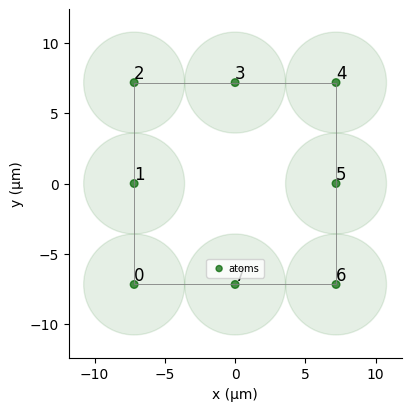

In [4]:
coords = R_interatomic * square_perimeter_points(square_length)
reg = pulser.Register.from_coordinates(coords)
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

And finally the pulse sequence that will realise the AFM state:

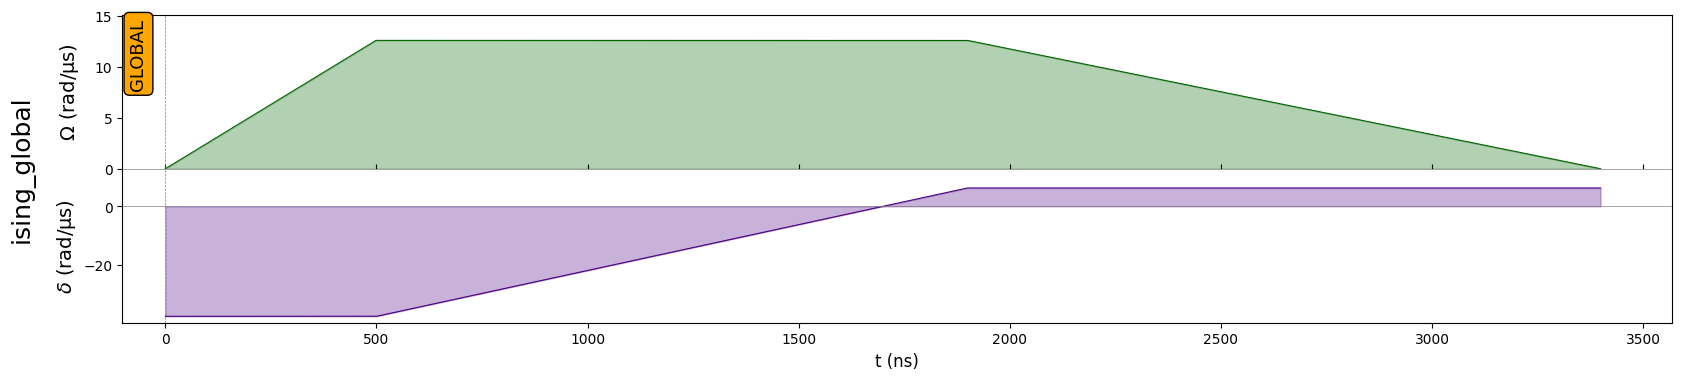

In [5]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, AnalogDevice
)
seq.draw("input")

### Using EMU-MPS as backend

As mentioned earlier, to run simulations with the EMU-MPS backend we need to provide as input a Pulse sequence - which we have just created - and a configuration object. 

We still have to create the configuration for the EMU-MPS backend. This is done via an instantiation of the configuration class `MPSConfig` which contains all the observables that we wish to measure and the time step chosen for the simulation, along with various algorithm specific parameters that are explained in the documentation.

We start by setting a bigger discretization time than the default one provided ($dt=10$) and enforcing that the times at which we compute the observables are an integer multiple of $dt$. For simplicity we will measure the observables only at the final time of the simulation.

We also fix the basis along which the measurements will be done. For the details regarding the conventions used we refer to the [Pulser documentation](https://pulser.readthedocs.io/en/stable/conventions.html).

In [6]:
dt = 100
final_time = (
    seq.get_duration() // dt * dt
)  # final_time should be a multiple of dt, and not exceed the sequence duration
eval_times = [final_time]

basis = {
    "r",
    "g",
}

#### BitString counts
It samples at desired time steps the evolved state, returning the *bitStrings* in a counter.

In [7]:
sampling_times = 1000
bitstrings = BitStrings(evaluation_times=eval_times, num_shots=sampling_times)

#### Fidelity

The *fidelity* is computed as $\langle \psi_{evolved} | \phi_{given} \rangle$ where 
- $\psi_{evolved}$ is the system state at desired steps
-  $\phi_{given}$ is the state in which we want to project the state system.

In this tutorial we will compute the fidelity against the dominant of the two antiferromagnetic states
 - $\phi_{given} = |rgrgrgrg>$

In [8]:
nqubits = len(seq.register.qubit_ids)

afm_string_pure = {"rgrgrgrg": 1}

afm_mps_state = MPS.from_state_string(
    basis=basis, nqubits=nqubits, strings=afm_string_pure
)
fidelity_mps_pure = Fidelity(evaluation_times=eval_times, state=afm_mps_state)

#### Qubit Density
It  is computed as $\langle \psi_{evolved} |\frac{(1+Z_i)}{2}|\psi_{evolved}\rangle$ and often  informally referred to as the *magnetization* at each atom site.

In [9]:
density = QubitDensity(
    evaluation_times=[x for x in range(0, final_time, dt)], basis=basis, nqubits=nqubits
)

#### Configuration object for EMU-MPS

In [10]:
mpsconfig = MPSConfig(
    dt=dt,
    observables=[
        bitstrings,
        fidelity_mps_pure,
        density,
    ],
)

### Finally we run

We instantiate the backend class `MPSBackend` and use its `run` method where we pass as argument the `sequence`  and the  `backend configuration` objects.

In [11]:
sim = MPSBackend()
results = sim.run(seq, mpsconfig)

step = 1/34, χ = 2, |ψ| = 0.001 MB, RSS = 11.681 MB, Δt = 0.222 s
step = 2/34, χ = 2, |ψ| = 0.001 MB, RSS = 11.681 MB, Δt = 0.152 s
step = 3/34, χ = 3, |ψ| = 0.002 MB, RSS = 11.681 MB, Δt = 0.160 s
step = 4/34, χ = 4, |ψ| = 0.002 MB, RSS = 11.681 MB, Δt = 0.195 s
step = 5/34, χ = 4, |ψ| = 0.002 MB, RSS = 11.681 MB, Δt = 0.186 s
step = 6/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.681 MB, Δt = 0.188 s
step = 7/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.681 MB, Δt = 0.202 s
step = 8/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.681 MB, Δt = 0.192 s
step = 9/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.681 MB, Δt = 0.198 s
step = 10/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.681 MB, Δt = 0.197 s
step = 11/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.681 MB, Δt = 0.191 s
step = 12/34, χ = 6, |ψ| = 0.004 MB, RSS = 11.681 MB, Δt = 0.185 s
step = 13/34, χ = 6, |ψ| = 0.004 MB, RSS = 11.681 MB, Δt = 0.184 s
step = 14/34, χ = 7, |ψ| = 0.005 MB, RSS = 11.681 MB, Δt = 0.182 s
step = 15/34, χ = 8, |ψ| = 0.006 MB, RSS = 11.681 MB, Δt = 0.174 s
step

During simulation time one has access to the following information: 
- step: the whole sequence is discretized by dt and this generates a number of steps. 
- $\chi$ : is the bond dimension
- $|\Psi|$: memory footprint
- RSS: max memory allocation
- $\triangle t$: time that the step took to run


## Inspecting the result object

In the following lines, we are going to give a brief code examples of how you can get the information from the results object

In [12]:
results.get_result_names()

['qubit_density', 'bitstrings', 'fidelity_0']

Note that the fidelity name contains an index, because it is possible to create several fidelities on different states, and the names must be unique.

#### Bitstrings analysis

Below we retreive the bistrings computed.

We observe that they were indeed computed only at a single time $ns = 3400$ and we find those that were sampled the highest number of times with their relative counting.

The most frequent bitstring is ['10101010'] which was sampled 262 times


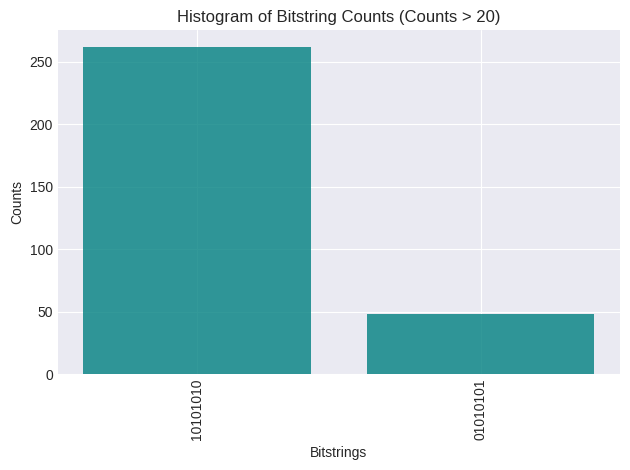

In [13]:
bitstrings_final = results[bitstrings.name][final_time]
results.get_result_times(bitstrings.name)

max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print(
    "The most frequent bitstring is {} which was sampled {} times".format(
        max_string, max_val
    )
)

filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))
with plt.style.context("seaborn-v0_8-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.show()

#### Fidelity analysis

Here we compute the fidelity of the system against the two different AFM state realisations defined above.  

In [14]:
fidelity_pure = results[fidelity_mps_pure.name][final_time]

print(
    "The fidelity computed for the system final state against the pure state |rgrgrgr> is {}.\nThe probability of the system being in that sate is equal to {} ".format(
        fidelity_pure, abs(fidelity_pure) ** 2
    )
)

The fidelity computed for the system final state against the pure state |rgrgrgr> is (0.48847401288711745-0.12589877885202355j).
The probability of the system being in that sate is equal to 0.2544573637824745 


### Evolution of the state in time

Here we plot the time evolution of the magnetization of the system sites and we observe how the system slowly reaches the AFM state.

In [15]:
magnetization_values = np.array(list(results[density.name].values()))
magnetization_times = results.get_result_times(density.name)

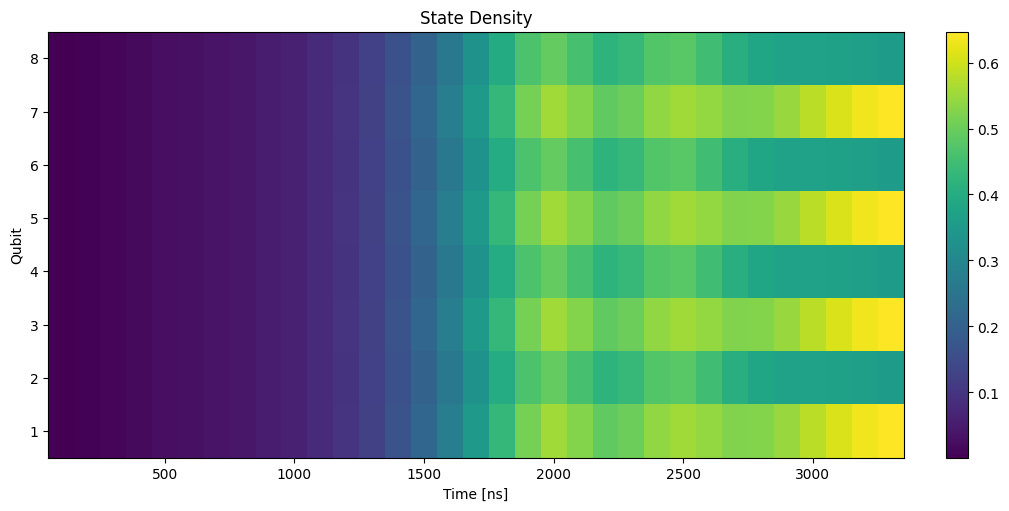

In [16]:
fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")

num_time_points, positions = magnetization_values.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = pcolormesh(magnetization_times, y, magnetization_values.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)